In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../python')
from functions import *
from models import *
import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Sideband region: [-8.4,-0.2]
Signal region: [-7.4,-1.2]
Total counts: SR = 273,610, SB = 72,437
Signal region has 368 stream and 273,242 bkg events (0.13%).
Sideband region has 25 stream and 72,412 bkg events (0.03%).
f_sig = 3.9X f_sideband.


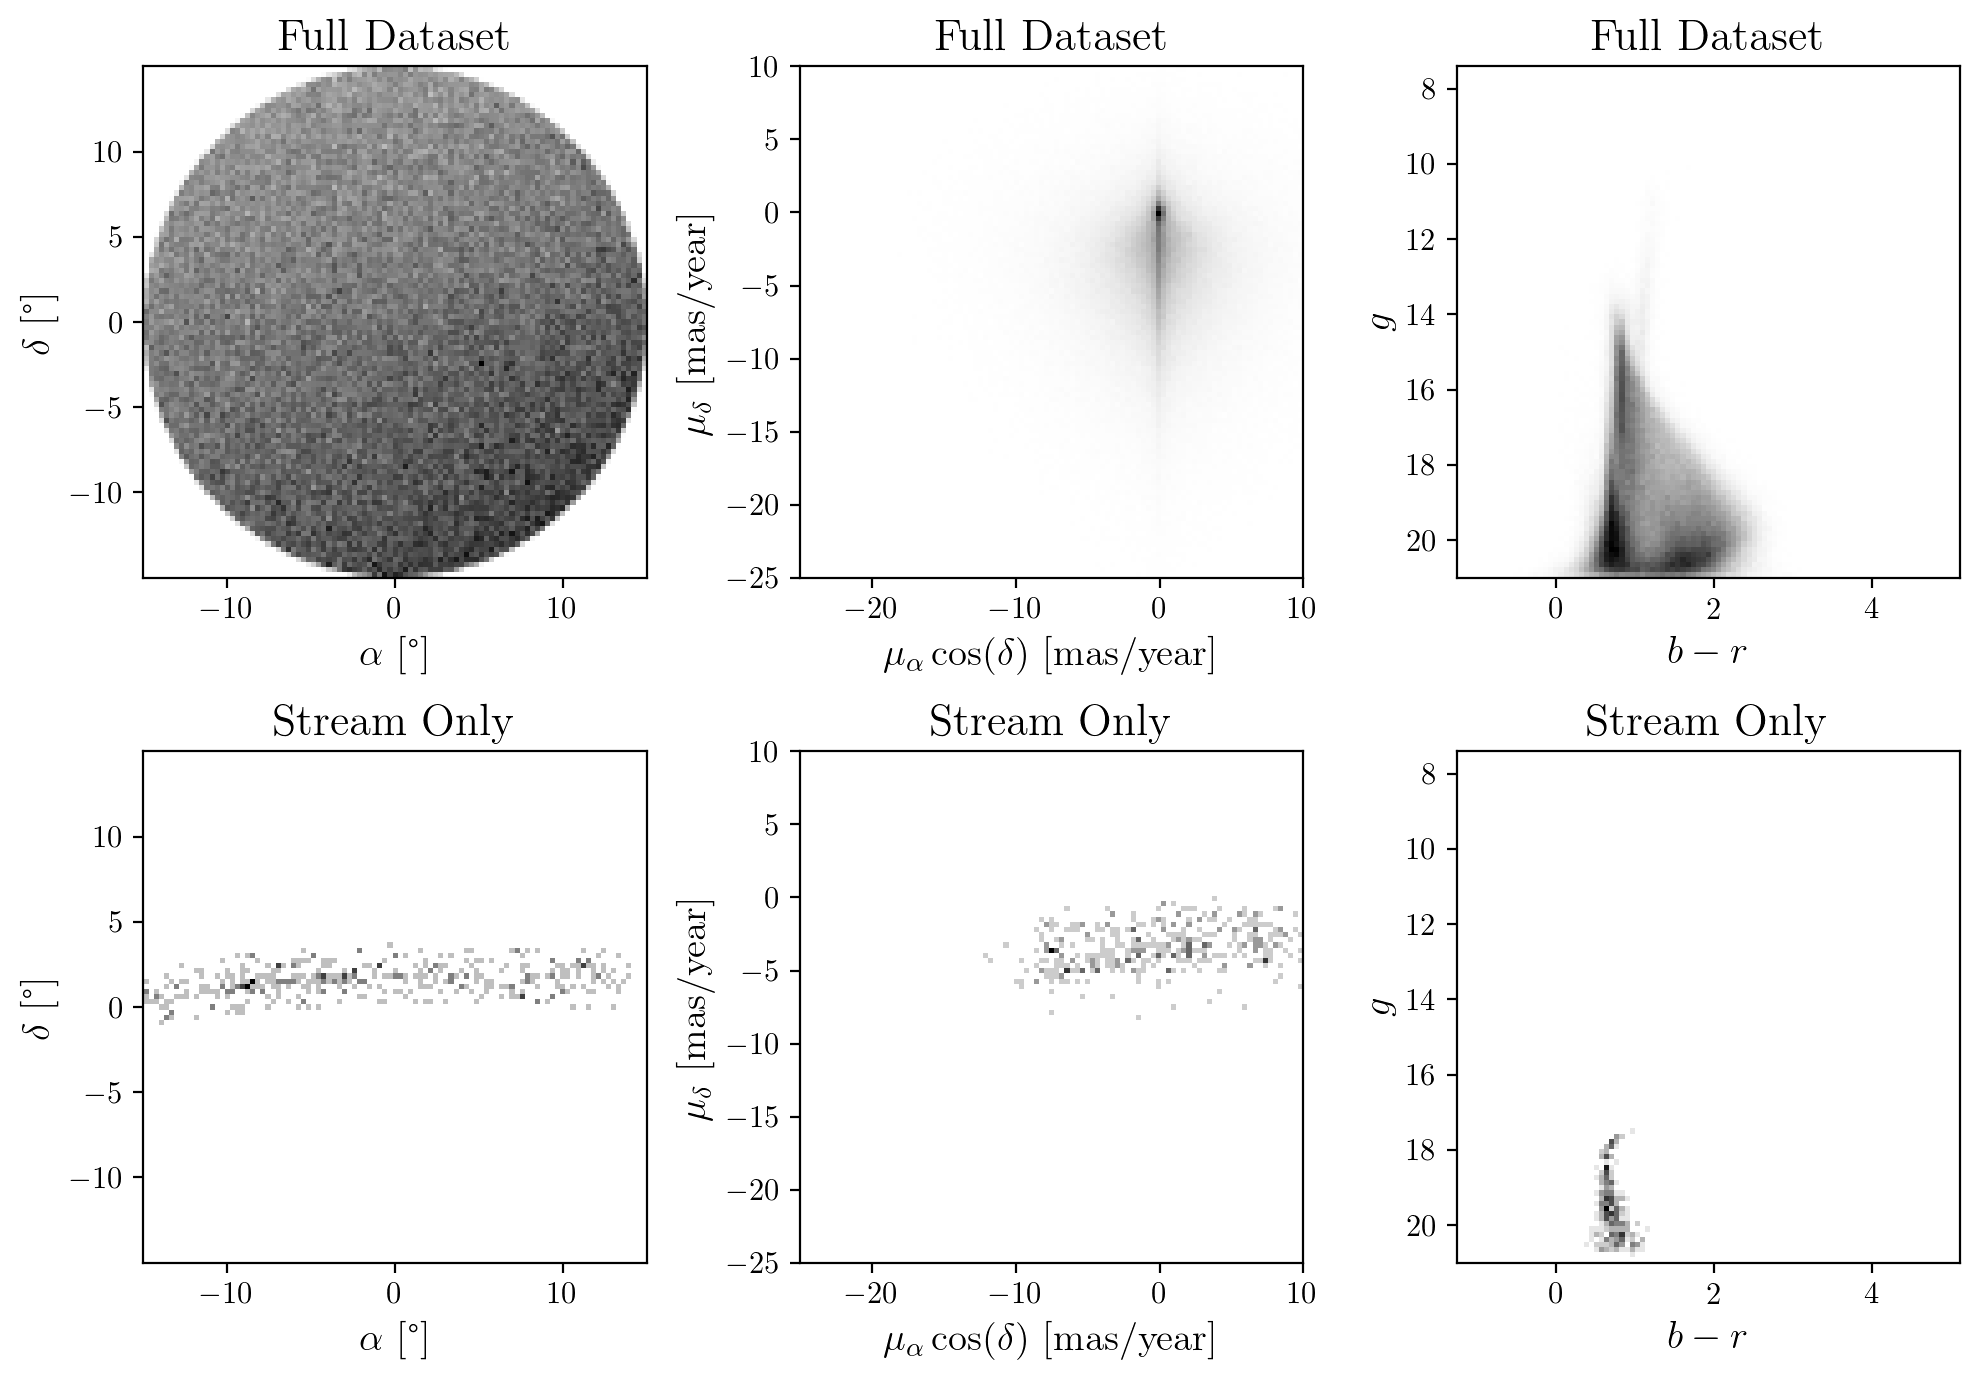

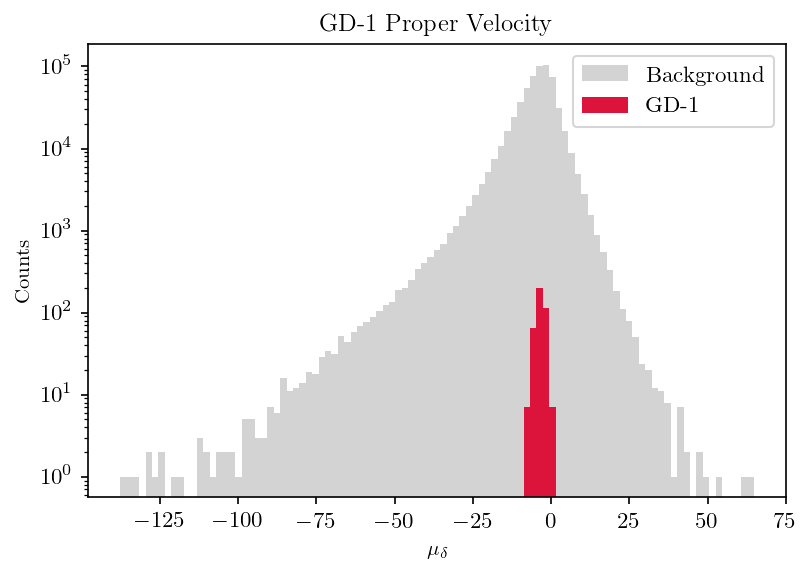

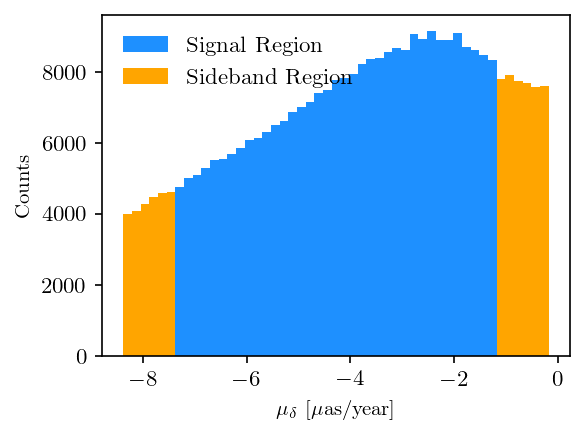

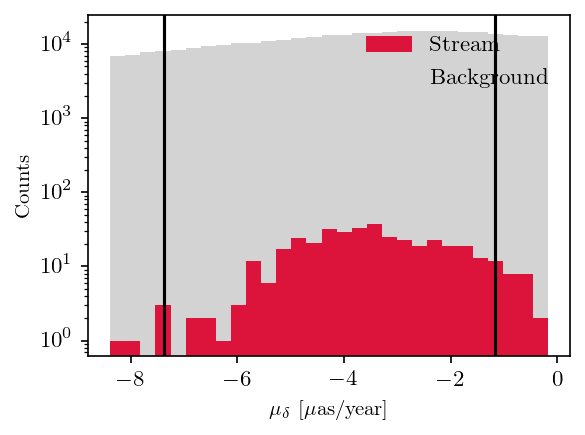

In [2]:
### Load data
stream = "gd1_tail"
df, file = load_file(stream = stream)
df = df.drop_duplicates(subset=['α','δ','μ_α','μ_δ','color','mag'])
weight=1 
df["weight"] = np.where(df['stream']==True, weight, 1)
save_folder = "../trained_models/test"
visualize_stream(df, save_folder=save_folder)
df_slice = signal_sideband(df)

In [4]:
### Train 

tf.keras.backend.clear_session()

df_test = train(df_slice, 
      n_folds = 5, 
      best_of_n_loops = 3,
      layer_size = 10, 
      batch_size = 1000, 
      dropout = 0.2, 
      epochs = 2, 
      l2_reg = 0,
      patience = 10,
      verbose = False,
      save_folder = save_folder, 
      # other_callbacks=PlotLossesKeras(),
                        )

False


Validation sets:   0%|          | 0/4 [00:00<?, ?it/s]

Folds:   0%|          | 0/5 [00:01<?, ?it/s]

KeyboardInterrupt



In [6]:
len(df_test)

346047

In [7]:
len(df_slice)

346047

Top 50 stars: Purity = 0.0% 


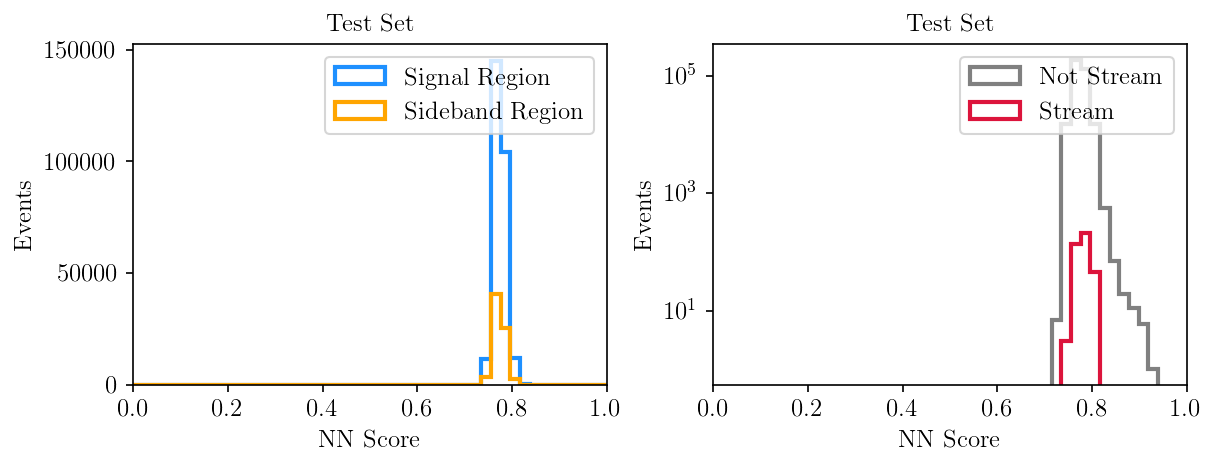

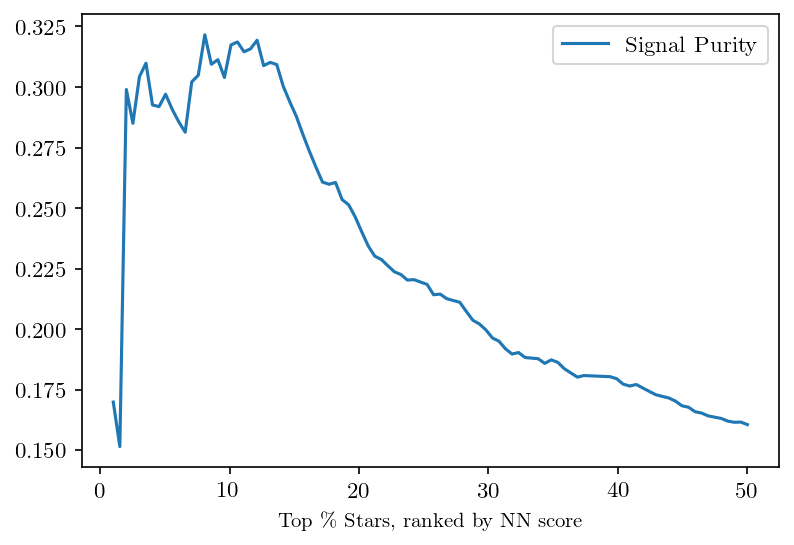

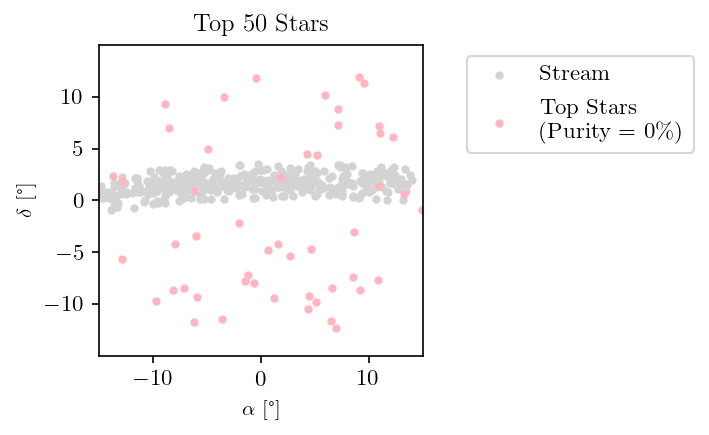

In [8]:
plot_results(df_test, 
             # save_folder = save_folder+"after_fiducial_cuts"
            )